In [10]:
from keras.src.backend.jax.numpy import linspace
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
MODEL_CKPT = "../../checkpoints/Best/ckpt_last.pt"   # path to your trained checkpoint
TEST_H5    = "../../DATA/test.h5"            # path to HDF5 test set with datasets: images, masks
CATALOG_CSV= "../../DATA/test.csv"           # path to catalog (injected trails with positions & metadata)

# Tiling parameters (should match training/eval input tiling)
TILE       = 128

In [155]:
import sys
from pathlib import Path
proj = Path("../../")
sys.path.insert(0, str(proj))
# Make "common.py" (used by simulate_inject.py) importable as a top-level module
sys.path.insert(0, str(proj / "ADCNN" / "data" / "dataset_creation"))
from torch.utils.data import DataLoader
from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full
import ADCNN.evaluation as evaluation
from ADCNN.utils.utils import draw_one_line
import numpy as np, h5py, pandas as pd, matplotlib.pyplot as plt

In [14]:
test_ds = H5TiledDataset(TEST_H5, tile=TILE, k_sigma=5.0)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
print("Tiles:", len(test_ds), "| images:", test_ds.N, f"| panel size: {test_ds.H}x{test_ds.W}")
model = load_model(MODEL_CKPT)
p_full = predict_tiles_to_full(TEST_H5, test_loader, model, tile=TILE)
print("Predictions shape:", p_full.shape)
with h5py.File(TEST_H5, "r") as _f:
    gt_full = _f["masks"][:].astype(np.uint8)

Tiles: 51200 | images: 50 | panel size: 4000x4072
Loaded model from: ../../checkpoints/Best/ckpt_last.pt
Predictions shape: (50, 4000, 4072)


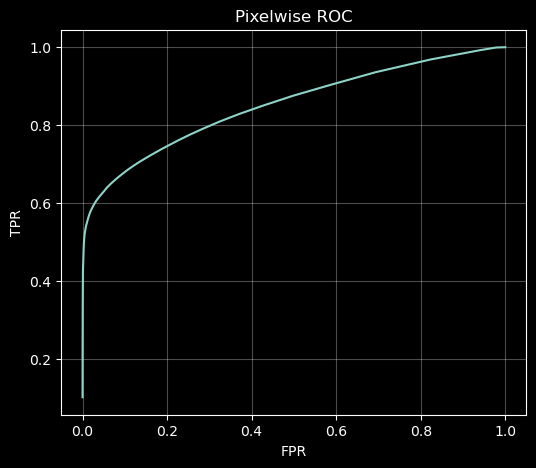

Pixelwise AUC: 0.8516


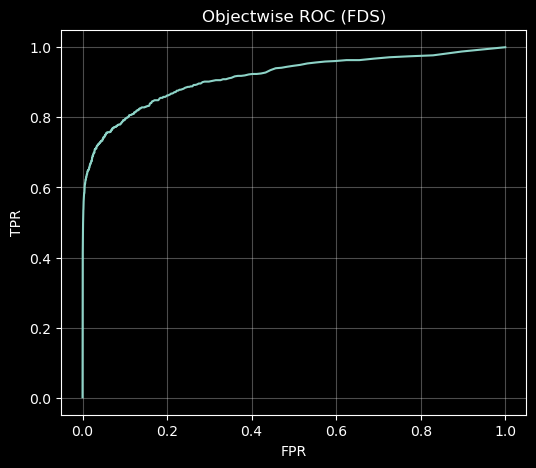

Objectwise AUC: 0.9153


In [165]:
# ---- Load GT masks once ----
with h5py.File(TEST_H5, "r") as _f:
    gt_full = _f["masks"][:].astype(np.uint8)

# ---- Pixelwise ROC ----
fpr_px, tpr_px, thr_px, auc_px = evaluation.pixelwise_roc_from_hist(p_full, gt_full, nbins=1024)
print(f"Pixelwise AUC: {auc_px:.4f}")

# ---- Objectwise ROC (FDS candidates) ----
base_thr = 0.05
cand_scores, cand_labels = evaluation.object_candidates_and_scores(p_full, gt_full, base_thr=base_thr, pixel_gap=2)
fpr_obj, tpr_obj, thr_obj, auc_obj = evaluation.roc_from_scores(
    pos_scores=cand_scores[cand_labels],
    neg_scores=cand_scores[~cand_labels],
    num_thresh=512
)
plt.figure(figsize=(6,5)); plt.plot(fpr_obj, tpr_obj)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Objectwise ROC (FDS)"); plt.grid(True, alpha=0.3); plt.show()
print(f"Objectwise AUC: {auc_obj:.4f}")

In [105]:
def objectwise_confusion (catalog, predictions, threshold, pixel_gap=10, psf_width=40):
    true_positive = 0
    false_negative = 0
    false_positive = 0

    predictions = predictions >= threshold
    for image_id in catalog["image_id"].unique():
        lab, n = evaluation._label_components_fds(predictions[image_id], pixel_gap=pixel_gap)
        predicted_positive = n
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = predictions[row["image_id"]] & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            predictions[row["image_id"]][lab_removed] = 0
            if np.any(intersection):
                true_positive += 1
            else:
                false_negative += 1
        false_positive += predicted_positive - true_positive if predicted_positive - true_positive >=0 else 0
    return true_positive, false_positive, false_negative

TP: 49 FP: 0 FN: 931 F1: 0.0952 F2: 0.0617


In [114]:
catalog = pd.read_csv(CATALOG_CSV)
f1_objectwise_list, f1_pixelwise_list = [], []
f2_objectwise_list, f2_pixelwise_list = [], []
tp_objectwise_list, tp_pixelwise_list = [], []
fp_objectwise_list, fp_pixelwise_list = [], []
fn_objectwise_list, fn_pixelwise_list = [], []
thresholds_list = []
for threshold in np.linspace(0.0, 1.0, 20):
    print(f"Threshold: {threshold:.4f}", end=" ")
    thresholds_list.append(threshold)
    (tp, fp, fn, _), (_, _, f1, f2) = evaluation.pixelwise_confusion(p_full, gt_full, thr=threshold)
    tp_pixelwise_list.append(tp), fp_pixelwise_list.append(fp), fn_pixelwise_list.append(fn)
    f1_pixelwise_list.append(f1)
    f2_pixelwise_list.append(f2)
    print("|| PIXELWISE   ", "TP:", tp, "FP:", fp, "FN:", fn, f"F1: {f1:.4f}", f"F2: {f2:.4f}", end=" ")
    tp, fp, fn = objectwise_confusion(catalog, p_full, threshold=threshold, pixel_gap=2, psf_width=40)
    tp_objectwise_list.append(tp), fp_objectwise_list.append(fp), fn_objectwise_list.append(fn)
    f1 = 2*tp/(2*tp + fp + fn)
    f2 = 5*tp/(5*tp + 4*fn + fp)
    f1_objectwise_list.append(f1)
    f2_objectwise_list.append(f2)
    print("|| OBJECTWISE  ", "TP:", tp, "FP:", fp, "FN:", fn, f"F1: {f1:.4f}", f"F2: {f2:.4f}")

Threshold: 0.0000 || PIXELWISE    TP: 987415 FP: 813412585 FN: 0 F1: 0.0024 F2: 0.0060 || OBJECTWISE   TP: 49 FP: 0 FN: 931 F1: 0.0952 F2: 0.0617
Threshold: 0.0526 || PIXELWISE    TP: 606083 FP: 30464958 FN: 381332 F1: 0.0378 F2: 0.0865 || OBJECTWISE   TP: 706 FP: 22574 FN: 274 F1: 0.0582 F2: 0.1298
Threshold: 0.1053 || PIXELWISE    TP: 569895 FP: 14738798 FN: 417520 F1: 0.0699 F2: 0.1480 || OBJECTWISE   TP: 647 FP: 5372 FN: 333 F1: 0.1849 F2: 0.3255
Threshold: 0.1579 || PIXELWISE    TP: 551006 FP: 10092068 FN: 436409 F1: 0.0948 F2: 0.1888 || OBJECTWISE   TP: 616 FP: 2193 FN: 364 F1: 0.3252 F2: 0.4577
Threshold: 0.2105 || PIXELWISE    TP: 539537 FP: 7691466 FN: 447878 F1: 0.1171 F2: 0.2215 || OBJECTWISE   TP: 596 FP: 1273 FN: 384 F1: 0.4184 F2: 0.5148
Threshold: 0.2632 || PIXELWISE    TP: 531085 FP: 6189457 FN: 456330 F1: 0.1378 F2: 0.2489 || OBJECTWISE   TP: 574 FP: 836 FN: 406 F1: 0.4803 F2: 0.5385
Threshold: 0.3158 || PIXELWISE    TP: 524021 FP: 5167709 FN: 463394 F1: 0.1569 F2: 0.2

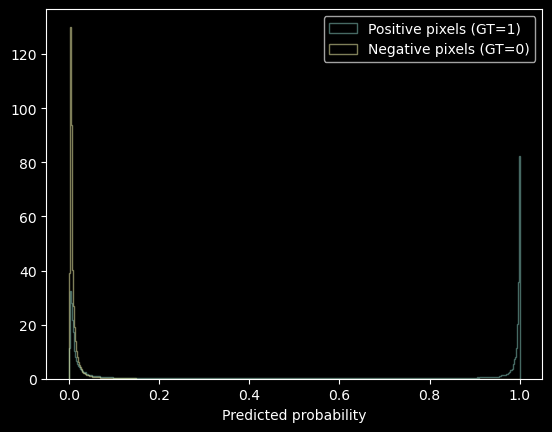

In [160]:
_ = plt.hist(p_full[gt_full==1].flatten(), bins=500, alpha=0.5, label="Positive pixels (GT=1)", density=True, histtype="step")
_ = plt.hist(p_full[gt_full==0].flatten(), bins=500, alpha=0.5, label="Negative pixels (GT=0)", density=True, histtype="step")
plt.xlabel("Predicted probability")
plt.legend()
plt.show()

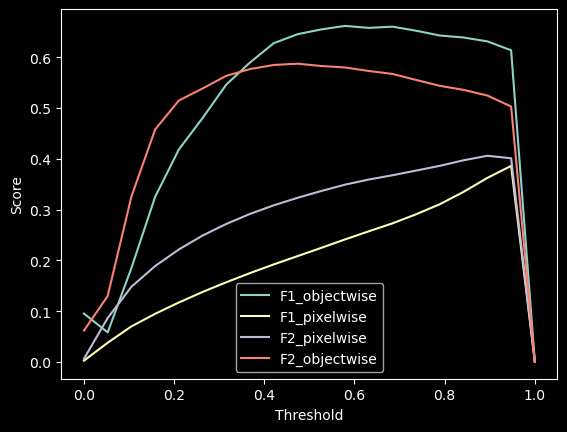

In [115]:
plt.plot(thresholds_list, f1_objectwise_list, label="F1_objectwise")
plt.plot(thresholds_list, f1_pixelwise_list, label="F1_pixelwise")
plt.plot(thresholds_list, f2_pixelwise_list, label="F2_pixelwise")
plt.plot(thresholds_list, f2_objectwise_list, label="F2_objectwise")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [156]:
def mark_nn_to_catalog (catalog, predictions, threshold, pixel_gap=10, psf_width=40):
    predictions = predictions >= threshold
    for image_id in catalog["image_id"].unique():
        lab, n = evaluation._label_components_fds(predictions[image_id], pixel_gap=pixel_gap)
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            index = np.argwhere((catalog["x"] == row["x"]) & (catalog["y"] == row["y"]) & (catalog["image_id"] == row["image_id"]))[0][0]
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = predictions[row["image_id"]] & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            predictions[row["image_id"]][lab_removed] = 0
            if np.any(intersection):
                catalog.at[index, "nn_detected"] = True
            else:
                catalog.at[index, "nn_detected"] = False
    return catalog

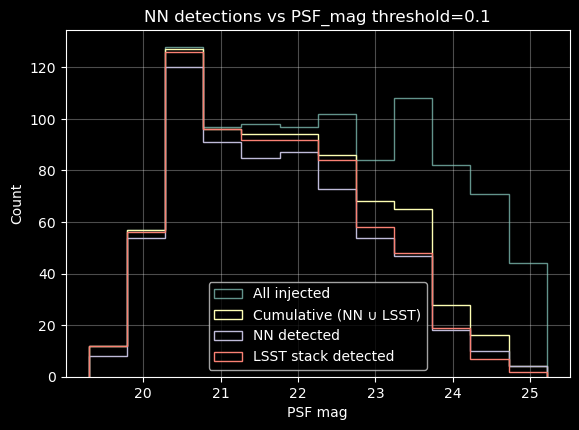

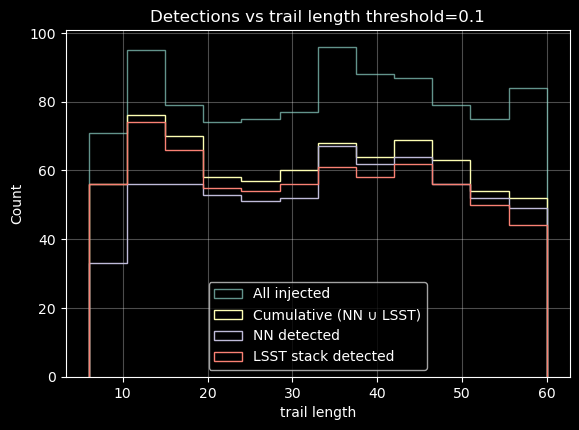

In [162]:
cat = mark_nn_to_catalog(catalog, p_full, threshold=0.1, pixel_gap=2, psf_width=40)
_ = evaluation.plot_detect_hist(cat, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=0.1")
_ = evaluation.plot_detect_hist(cat, "trail_length", bins=12, title="Detections vs trail length threshold=0.1")
_ = plt.show()

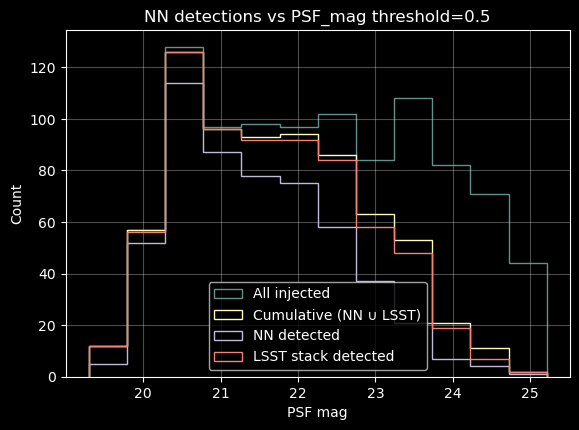

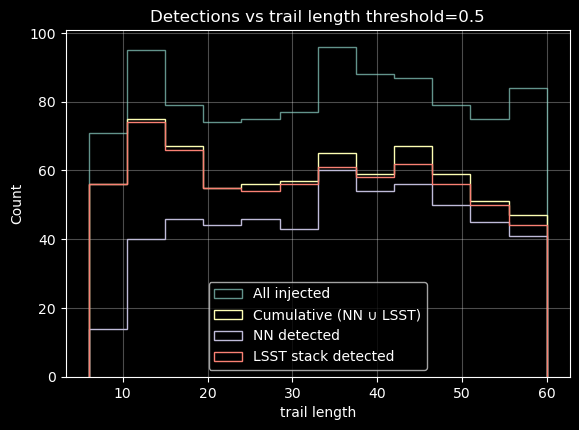

In [163]:
cat = mark_nn_to_catalog(catalog, p_full, threshold=0.5, pixel_gap=2, psf_width=40)
_ = evaluation.plot_detect_hist(cat, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=0.5")
_ = evaluation.plot_detect_hist(cat, "trail_length", bins=12, title="Detections vs trail length threshold=0.5")
_ = plt.show()

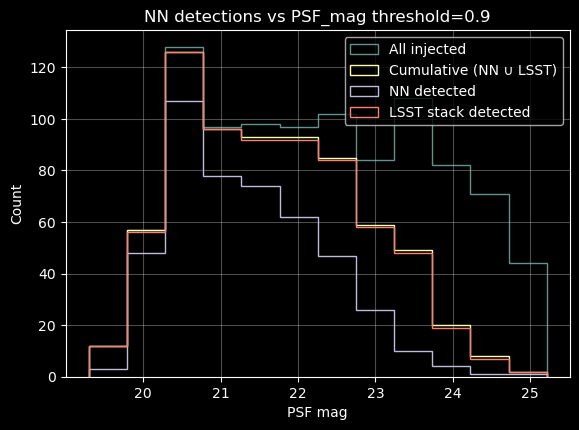

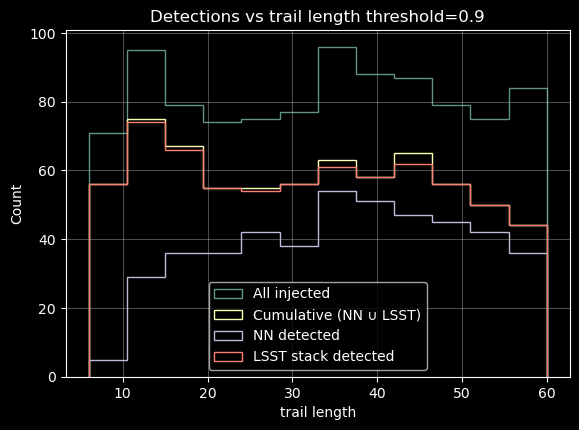

In [164]:
cat = mark_nn_to_catalog(catalog, p_full, threshold=0.9, pixel_gap=2, psf_width=40)
_ = evaluation.plot_detect_hist(cat, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=0.9")
_ = evaluation.plot_detect_hist(cat, "trail_length", bins=12, title="Detections vs trail length threshold=0.9")
_ = plt.show()